# Transfer Learning

* 🤯 Tech companies and university labs have more computational resources than we do
* 😎 Let them train their  super complex models on millions of images, and could re-use their kernels for our own CNNs !

🎯 **<u>Goal:</u>**
* ☄️ Use a **Pretrained Neural Network** $ \Leftrightarrow $ let's do some **`Transfer learning`**

## (1) What is a Pre-Trained Neural Network ?

* Convolutions are mathematical operations designed to detect specific patterns in input images and use them to classify the images. 
* One could imagine that these patterns are not 100% specific to one task but to the input images. 

💡 Therefore, **why not `re-using these kernels - whose weights have already been optimized - somewhere else`  ?** 
with the expectation that these trained kernels could also help us perform another classification task ?

👀 What we are talking about here is the **`transfer`** of a CNN knowledge to a new classification task.

🔥 $\rightarrow$ **`Transfer Learning`** has two  main advantages:
- It takes less time to train a pre-trained model since we are not going to update all the weights but only the some of them
- You benefit from state-of-the-art architectures that have been trained on complex images. 

## (2) Introduction to  VGG16 

📚 ***Reading Section, no code***






In this exercise, we will use the <a href="https://neurohive.io/en/popular-networks/vgg16/">**`VGG-16 Neural Network`**</a>.

> VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.

VGG16 is a well-known architecture that has been trained on the <a href="https://www.image-net.org/">**`ImageNet dataset`**</a> which is a very large database of images which belong to different categories. 

👉 This architecture already learnt what kernels are supposed to be the best for extracting features from the images found in the `ImageNet dataset`.

👉 As you can see in the illustration, the VGG16 involves millions of parameters you don't want to retrain yourself.


<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width=400></center>

❓ How does it work in practice ❓

* The first layers are not specialized for the particular task the VGG16 CNN was trained on
* Only the last dense layers are "classification layers"... Therefore, we will: 
    1. Load the existing VGG16 network
    2. Remove the last fully connected layers
    3. Replace them by some new fully-connected layers (whose weights are randomly set)
    4. Train these last layers on a specific classification task. 

😃 Your role is to train  only learn the last layers for your particular problem.

🤓 We'll use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16">**`tensorflow.keras.applications.VGG16`**</a>

<hr>

## (3) Data loading & Preprocessing

You have two options to load the data on Google Colab.

### (Option 1) Loading the data directly

* You can first get the data onto google Colab thanks to:

`!wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip`,

* and then run 

`!unzip flowers-dataset.zip`

*This is a very easy option to load the data into your working directory.*

### (Option 2) Adding the data to Google Drive

* You can first download the data  from `https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip`. 
* Then you have to add them to your Google Drive in a folder called `Deep_learning_data` (for instance)
* And run the following code in the notebook: 

```python
from google.colab import drive
drive.mount('/content/drive/')
```

* The previous code will ask you to go to a given webpage where you can copy a temporary key
* Paste it in the cell that will appear in your Colab Notebook
* You can now load the data on your Google Colab Notebooks

### Option 1 or Option 2 ?

* Why choosing option 2 over the option 1? 
    * ✅ The combo Colab + Drive can be interesting if you work within a project team, and need to update the data from time to time. 
    * ✅ By doing this, you can share the same data folder with your teammates, and be sure that everyone has the same dataset at any time, even though someone changes it. 
    * ❌ Google Colab has now access to your Google Folder..., which you might not be or not in favor of, depending on your sensibility...

---

❓ **Question: Loading your dataset** ❓ 
    
Use one of the above method to load your data

In [ ]:
option_1 = True # Choose here

if option_1:
    !wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
    !unzip flowers-dataset.zip
else:
    from google.colab import drive
    drive.mount('/content/drive/')

--2022-02-16 14:38:41--  https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.61.154
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.61.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104983809 (100M) [application/zip]
Saving to: ‘flowers-dataset.zip’

flowers-dataset.zip 100%[===================>] 100.12M  24.9MB/s    in 4.6s    

2022-02-16 14:38:46 (21.6 MB/s) - ‘flowers-dataset.zip’ saved [104983809/104983809]

Archive:  flowers-dataset.zip
  inflating: flowers/daisy/2607132536_d95198e619_n.jpg  
  inflating: flowers/daisy/6480809771_b1e14c5cc2_m.jpg  
  inflating: flowers/daisy/9350942387_5b1d043c26_n.jpg  
  inflating: flowers/daisy/4065883015_4bb6010cb7_n.jpg  
  inflating: flowers/daisy/7924174040_444d5bbb8a.jpg  
  inflating: flowers/daisy/8740807508_0587f5b7b7.jpg  
  inflating: flo

In [ ]:
!pwd

/content


In [ ]:
!ls

flowers  flowers-dataset.zip  sample_data


❓ **Question:Train/Val/Test split** ❓ 

Use the following method to create 
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `loading_method` you have used

In [ ]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_flowers_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/Deep_learning_data/flowers'
    elif loading_method == 'direct':
        data_path = 'flowers/'
    classes = {'daisy':0, 'dandelion':1, 'rose':2}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [ ]:
# CALL load_flowers_data WITH YOUR PREFERRED METHOD HERE
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data('direct')


100%|██████████| 299/299 [00:03<00:00, 92.40it/s]


❓ **Question: Exploring the images** ❓

Check the images' shapes and plot few of them.

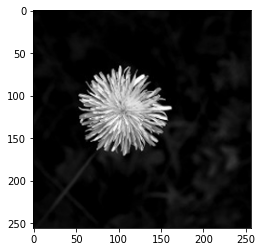

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])
plt.show()

In [ ]:
y_train.shape

(571, 3)

## (4) A CNN architecture

First, let's build our own CNN.

❓ **Questions** ❓ 

1. <u>CNN Architecture and compiler:</u> Create a CNN with your own architecture and a function `load_own_model` that will be able to generate it. Some advices:
    - Incorporate the Rescaling layer in your Sequential architecture
    - Add three Conv2D/MaxPooling2D combinations with an increasing size of channels and a decreasing size of kernels for example (be creative, that is not a rule of thumb, mastering CNN is an art)
    - Don't forget the Flatten layer and some hidden layers
    - Finish wit the predictive layer
    - Compile your CNN model accordingly
  
  
2. <u>Training and comparison</u>:
    - Train your CNN
    - Compare its performance to a baseline accuracy

<details>
    <summary><i>Recommended architecture:</i></summary>

```python
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

model = Sequential()

# Notice this cool new layer that "pipe" your rescaling within the architecture
model.add(Rescaling(1./255, input_shape=(256,256,3)))

# Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
```

        
</details>        

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers, models

def initialize_model():
  
  model = models.Sequential()

  # Notice this cool new layer that "pipe" your rescaling within the architecture
  model.add(Rescaling(1./255, input_shape=(256,256,3)))

  # Lets add 3 convolution layers, with relatively large kernel size as our pictures are quite big too
  model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
  model.add(layers.MaxPooling2D(3))

  model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
  model.add(layers.MaxPooling2D(3))

  model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
  model.add(layers.MaxPooling2D(3))

  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
    
  ### Model compilation
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])   

  return model


In [ ]:
model = initialize_model()
model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=50)

Epoch 1/50
18/18 [==============================] - 16s 196ms/step - loss: 0.5885 - accuracy: 0.4746 - val_loss: 0.4783 - val_accuracy: 0.5140
Epoch 2/50
18/18 [==============================] - 2s 84ms/step - loss: 0.5250 - accuracy: 0.5219 - val_loss: 0.4966 - val_accuracy: 0.4916
Epoch 3/50
18/18 [==============================] - 2s 85ms/step - loss: 0.5242 - accuracy: 0.5587 - val_loss: 0.4692 - val_accuracy: 0.6034
Epoch 4/50
18/18 [==============================] - 2s 84ms/step - loss: 0.5114 - accuracy: 0.5867 - val_loss: 0.4893 - val_accuracy: 0.5531
Epoch 5/50
18/18 [==============================] - 2s 86ms/step - loss: 0.4931 - accuracy: 0.6130 - val_loss: 0.5119 - val_accuracy: 0.5363
Epoch 6/50
18/18 [==============================] - 2s 85ms/step - loss: 0.4722 - accuracy: 0.6585 - val_loss: 0.4538 - val_accuracy: 0.6089
Epoch 7/50
18/18 [==============================] - 2s 85ms/step - loss: 0.4430 - accuracy: 0.6953 - val_loss: 0.4245 - val_accuracy: 0.6927
Epoch 8/50


In [ ]:
res = model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 118ms/step - loss: 2.4846 - accuracy: 0.6510


In [ ]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 65.0 %


🥡 <b><u>Takeaways from building your own CNN</u></b>:
* On an "easy dataset" like the MNIST, it is now easy to reach a decent accuracy. But for a more complicated problem like classifying flowers, it already becomes more challenges. Take a few minutes to play with the following link before moving on to Transfer Learning
    * [PoloClub/CNN-Explainer](https://poloclub.github.io/cnn-explainer/)

## (5) Using a pre-trained CNN = Transfer learning

As we said in the beginning Tech companies and university labs have more computational resources than we do.

🔥 The [**Visual Geometry Group**](https://www.robots.ox.ac.uk/~vgg/data/) *(Oxford University, Department of Science and Engineering)* became famous for some of their **Very Deep Convolutional Neural Networks** : the [**VGG16**](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

Take 7 min of your time to watch this incredible video of Convolutional Layers created by Dimitri Dmitriev.

📺 **[VGG16 Neural Network Visualization](https://www.youtube.com/watch?v=RNnKtNrsrmg)**


### (5.1) Load VGG16 model

❓ **Question: loading the VGG16** ❓ 

* Write a first function `load_model()` that loads the pretrained VGG-16 model from `tensorflow.keras.applications.vgg16`. Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚

* We will **load the VGG16 model** the following way:
    - 🤯 Let's use the **weights** learned on the [**imagenet dataset**](https://www.image-net.org/download.php) (14M pictures with 20k labels)
    - The **`input_shape`** corresponds to the common input shape of your images 
        - Note: *You have to resize them down to a common shape if they have different height/widths/channels*
    - The **`include_top`** argument should be set to `False`: 
        - to avoid loading the weights of the fully-connected layers of the VGG16
        - and also remove the last layer of the VGG16 which was specifically trained on `imagenet`

<i><u>Remark:</u></i> Do not change the default value of the other arguments

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    
    model = VGG16()
    
    return model

❓ **Question: number of parameters in the VGG16** ❓ 

Look at the architecture of the model using ***.summary()***

In [ ]:
# YOUR CODE HERE
model = load_model()
model.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png">

💪 Impressive, right? Two things to notice:
- It ends with a combo Conv2D/MaxPooling2D 
- The `layers.Flatten` and the `layers.Dense` are not here yet, we need to add them.
- There are more than 14.000.000 parameters, which is a lot... 
    - We could fine-tune them, i.e. update them as we will update the weights of the dense layers, but it will take a lot of time....
    - For this reason, we will inform the model that the layers until the flattening will be set non-trainable.

---

❓ **Question: deactivating the training of the VGG16 paramters** ❓ 

* Write a first function which:
    - takes the previous model as the input
    - sets the first layers to be non-trainable, by applying **`model.trainable = False`**
    - returns the model.

* Then inspect the summary of the model to check that the parameters are no longer trainable, they were set to be  **`non-trainable`**.



In [ ]:
len(model.layers)

23

In [ ]:
def set_nontrainable_layers(model):
    
    for i in model.layers[-3:]:
      i.trainable=False
    
    return model

In [ ]:
model = set_nontrainable_layers(model)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

❓ **Question: chaining the pretrained convolutional layers of VGG16 with our own dense layers** ❓ 

We will write a function that adds flattening and dense layers after the convolutional layers. To do so, we cannot directly use the classic `layers.Sequential()` instantiation.

For that reason, we will discover another one here. The idea is that we define each layer (or group of layers) separately. Then, we concatenate them. Have a look at this example : 

---
```python
base_model = load_model()
base_model = set_nontrainable_layers(base_model)
flattening_layer = layers.Flatten()
dense_layer = layers.Dense(SOME_NUMBER_1, activation='relu')
prediction_layer = layers.Dense(SOME_NUMBER_2, activation='APPROPRIATE_ACTIVATION')

model = tf.keras.Sequential([
  base_model,
  flattening_layer,
  dense_layer,
  prediction_layer
])

```
---

* The first line loads a group of layer which is the previous VGG-16 model. 
* Then, we set this layers to be non-trainable.
* Eventually, we can instantiate as many layers as we want.
* Finally, we use the `Sequential` with the sequence of layers that will correspond to our overall neural network. 

Replicate the following steps by adding:
* a flattening layer
* two dense layers (the first with 500 neurons) to the previous VGG-16 model.

In [ ]:
from tensorflow.keras import layers, models, Sequential

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')
    
    model = Sequential([
            base_model,
            flattening_layer,
            dense_layer,
            prediction_layer
          ])
    
    return model

❓ **Question: inspect the parameters of a customized VGG16** ❓ 

* Now look at the layers and the parameters of your model. 
* Note that there is a distinction, at the end, between the **trainable** and **non-trainable parameters**

In [ ]:
# YOUR CODE HERE
model = load_model()
model = add_last_layers(model)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 138,859,547
Trainable params: 15,216,691
Non-trainable params: 123,642,856
_________________________________________________________________


❓ **Question: building a function that creates a full customized VGG16 and compiles it** ❓ 

* Write a function which builds and compiles your model
    * We advise the _adam_ optimizer with `learning_rate=1e-4`. 

In [ ]:
from tensorflow.keras import optimizers
import tensorflow as tf

def build_model():
    model = load_model()
    model = add_last_layers(model)
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy']) 
    return model


### (5.2) Back to the data

🚨 The VGG16 model was trained on images which were preprocessed in a specific way. This is the reason why we did _NOT_ normalize them earlier.

❓ **Question: preprocessing the dataset** ❓ 

Apply the specific processing to the original (non-normalized) images here using the method **`preprocess_input`** that you can import from **`tensorflow.keras.applications.vgg16`**

📚 Cf. [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# YOUR CODE HERE
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)

In [ ]:
X_train.shape

(571, 256, 256, 3)

### (5.3)  Fit the model



❓ **Question: Training the customized VGG16** ❓ 

* Train the model with an Early stopping criterion on the validation accuracy -
* Since the validation data are provided, therefore use `validation_data` instead of `validation_split`.

_As usual, store the results of your training into a `history` variable._

In [ ]:
X_train.shape

(571, 256, 256, 3)

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.callbacks import EarlyStopping

model = build_model()
es = EarlyStopping(patience=5)
X_train = tf.image.resize(
    X_train, (224,224))
X_val = tf.image.resize(
    X_val, (224,224))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=50, callbacks=es)

Epoch 1/50
18/18 [==============================] - 37s 2s/step - loss: 1.0973 - accuracy: 0.3835 - val_loss: 1.0957 - val_accuracy: 0.3743
Epoch 2/50
18/18 [==============================] - 16s 919ms/step - loss: 1.0996 - accuracy: 0.3275 - val_loss: 1.0970 - val_accuracy: 0.3743
Epoch 3/50
18/18 [==============================] - 16s 915ms/step - loss: 1.0991 - accuracy: 0.3275 - val_loss: 1.0982 - val_accuracy: 0.3743
Epoch 4/50
18/18 [==============================] - 16s 915ms/step - loss: 1.0986 - accuracy: 0.3275 - val_loss: 1.0989 - val_accuracy: 0.3743
Epoch 5/50
18/18 [==============================] - 16s 915ms/step - loss: 1.0985 - accuracy: 0.3380 - val_loss: 1.1004 - val_accuracy: 0.2682
Epoch 6/50
18/18 [==============================] - 17s 931ms/step - loss: 1.0982 - accuracy: 0.3538 - val_loss: 1.1006 - val_accuracy: 0.2682


❓ **Question: Looking at the accuracy** ❓ 

Plot the accuracy for both the train set and and the validation set using the usual function below

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
# YOUR CODE HERE
plot_history(history)

❓ **Question: Evaluating the model** ❓

Evaluate the customized VGG16 accuracy on the test set. Did we improve?

In [ ]:
# YOUR CODE HERE
X_test = tf.image.resize(X_test, (224,224))

test_accuracy_vgg = model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 281ms/step - loss: 1.0996 - accuracy: 0.3356


## (6) (Optional) Improve the model

You can here try to improve the model test accuracy. To do that, here are some options you can consider

1. **Unfreeze and finetune**: Source: [Google tutorial](https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning) 
>_Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind. It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way._


1. Add **data augmentation** if your model is overfitting. 

2. If your model is not overfitting, try a more complex model.

3. Perform precise **grid search** on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

4. **Change the base model** to more modern one CNN (ResNet, EfficientNet1,... available in the keras library)

5. Curate the data: maintaining a sane data set is one of the keys to success.

6. Collect more data

## (6.2) Comparing the performances of the CNN, the VGG, and the VGG trained on the augmented dataset

In [ ]:
test_accuracy_aug = res_aug[-1]


print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')



test_accuracy_aug = 34.0 %


NameError: ignored

---

🏁 **Congratulations** 🏁 

1. Download this notebook from your `Google Drive` or directly from `Google Colab` 
2. Drag-and-drop it from your `Downloads` folder to your local `[GITHUB_USERNAME]/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/04-transfer-learning`


💾 Don't forget to push your 

3. Follow the usual procedure on your terminal in the `06-Deep-Learning/03-Convolutional-Neural-Networks/004-transfer-learning` folder:
      * *git add cifar_classification.ipynb*
      * *git commit -m "I am the god of Transfer Learning"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

🚀 If you have time, move on to the **Autoencoders** challenge!